In [ ]:
!pip install wget git+https://github.com/huggingface/transformers
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-w_rycvxq
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-w_rycvxq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 51.7 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
  Created wheel for transformers: filename=transformers-4.20.0.dev0-py3-none-any.whl size=4342386 sha256=3d843699b906ac3e46d10017b368e85283a1b8fc0fa06d154fa94d2e504ad6d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ddc9c7ug/wheels/35/2e/a7/d819e3310040329f0f47e57c9e3e7a7338aa5e74c49acfe522
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=3cf10c5fd4d9fd0bc8aa11a06db5519c87b5c203b0

In [ ]:
import tensorflow as tf
import torch
import wget
import os
import pandas as pd
import json
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup, BertTokenizer
import random
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker

In [ ]:
device = torch.device("cuda")
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [ ]:
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.drop(columns=['sentence_source', 'label_notes'], inplace=True)
with open('cola.json') as f:
  slang = json.loads(f.read())
  df_slang = df.copy()
  df_slang['sentence'] = slang


df_ood = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df_ood.drop(columns=['sentence_source', 'label_notes'], inplace=True)
with open('cola_ood.json') as f:
  df_slang_ood = df_ood.copy()
  df_slang_ood['sentence'] = json.loads(f.read())

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
def encode_sentences(sentences, labels):
  input_ids = []
  attention_masks = []
  for sent in sentences:
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                     )
      input_ids.append(encoded_dict['input_ids'])
      attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

input_ids, attention_masks, labels = encode_sentences(df.sentence.values, df.label.values)
slang_input_ids, slang_attention_masks, slang_labels = encode_sentences(df_slang.sentence.values, df.label.values)
ood_input_ids, ood_attention_masks, ood_labels = encode_sentences(df_ood.sentence.values, df_ood.label.values)
ood_slang_input_ids, ood_slang_attention_masks, ood_slang_labels = encode_sentences(df_slang_ood.sentence.values, df_slang_ood.label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)
slang_dataset = TensorDataset(slang_input_ids, slang_attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
slang_train_dataset, slang_val_dataset = random_split(slang_dataset, [train_size, val_size])
prediction_dataset = TensorDataset(ood_input_ids, ood_attention_masks, ood_labels)
slang_prediction_dataset = TensorDataset(ood_slang_input_ids, ood_slang_attention_masks, ood_slang_labels)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def run_experiment(train_dataset, val_dataset, prediction_dataset):
  batch_size = 32

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  prediction_dataloader = DataLoader(prediction_dataset, sampler=SequentialSampler(prediction_dataset), batch_size=batch_size)

  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--2 for binary classification.
                      # You can increase this for multi-class tasks.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()
  optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
  epochs = 4

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          res = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels)
          loss, logits = res.loss, res.logits

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              res = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              loss, logits = res.loss, res.logits
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  df_stats = pd.DataFrame(data=training_stats)
  df_stats = df_stats.set_index('epoch')

  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=3)
  plt.rcParams["figure.figsize"] = (12, 12)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])

  plt.show()
  model.eval()

  # Tracking variables 
  predictions, true_labels = [], []

  # Predict 

  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  matthews_set = []
  for i in range(len(true_labels)):
    
    # The predictions for this batch are a 2-column ndarray (one column for "0" 
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    
    # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
    matthews_set.append(matthews)
  
  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)
  for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 2 != 0:
        label.set_visible(False)

  plt.title('MCC Score per Batch')
  plt.ylabel('MCC Score (-1 to +1)')
  plt.xlabel('Batch #')

  plt.show()
  # Combine the results across all batches. 
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # Calculate the MCC
  mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
  return mcc

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.51
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.47
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.32
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.52
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
 

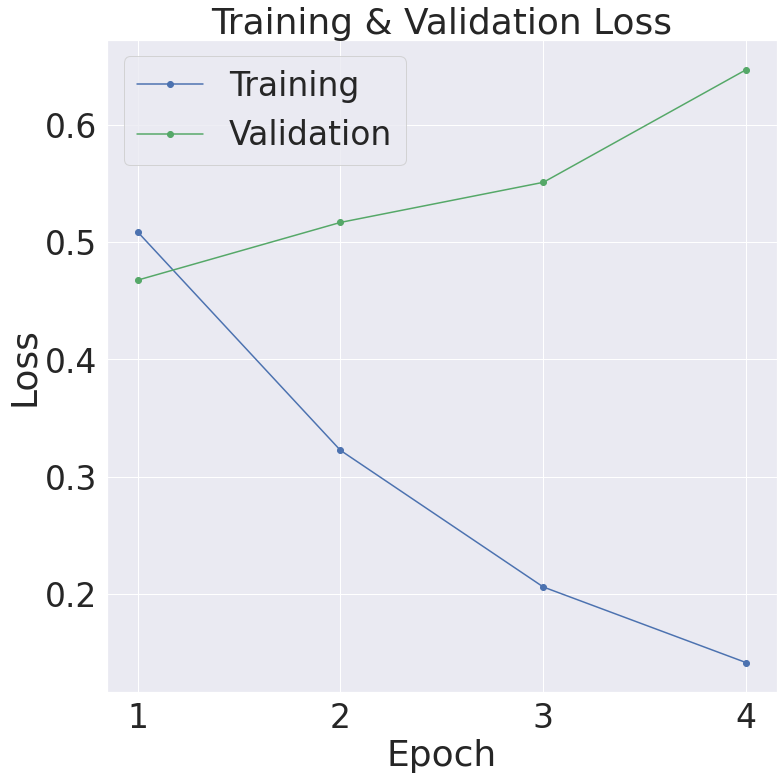

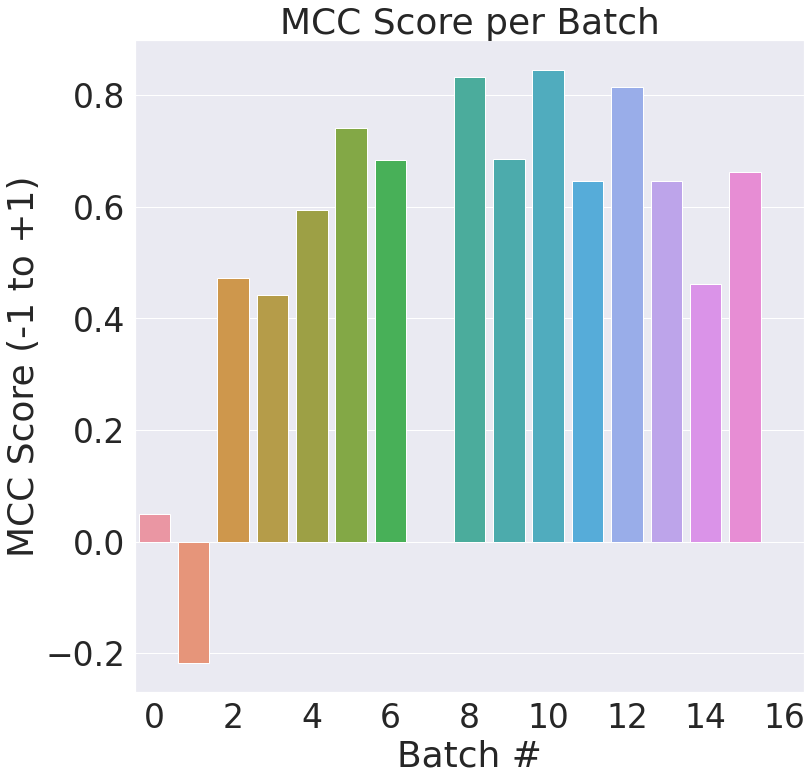

In [ ]:
result_normal_normal = run_experiment(
    train_dataset, val_dataset, prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:16.
  Batch   120  of    481.    Elapsed: 0:00:24.
  Batch   160  of    481.    Elapsed: 0:00:32.
  Batch   200  of    481.    Elapsed: 0:00:40.
  Batch   240  of    481.    Elapsed: 0:00:48.
  Batch   280  of    481.    Elapsed: 0:00:56.
  Batch   320  of    481.    Elapsed: 0:01:04.
  Batch   360  of    481.    Elapsed: 0:01:12.
  Batch   400  of    481.    Elapsed: 0:01:20.
  Batch   440  of    481.    Elapsed: 0:01:27.
  Batch   480  of    481.    Elapsed: 0:01:35.

  Average training loss: 0.51
  Training epcoh took: 0:01:36

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.45
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:16.
  Batch   120  of    481.    Elapsed: 0:00:24.
  Batch   160  of    481.    Elapsed: 0:00:32.
  Batch  

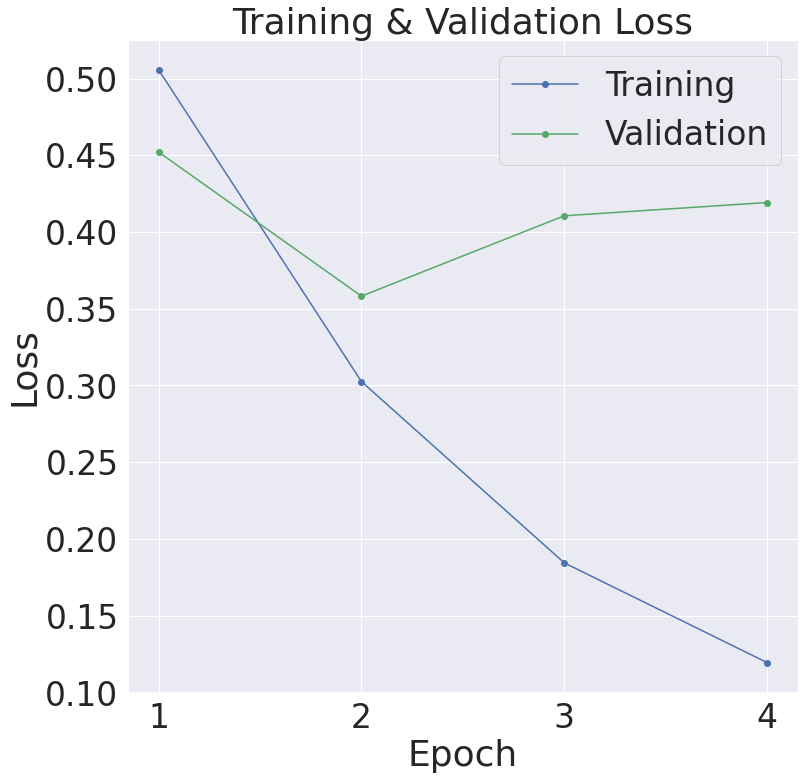

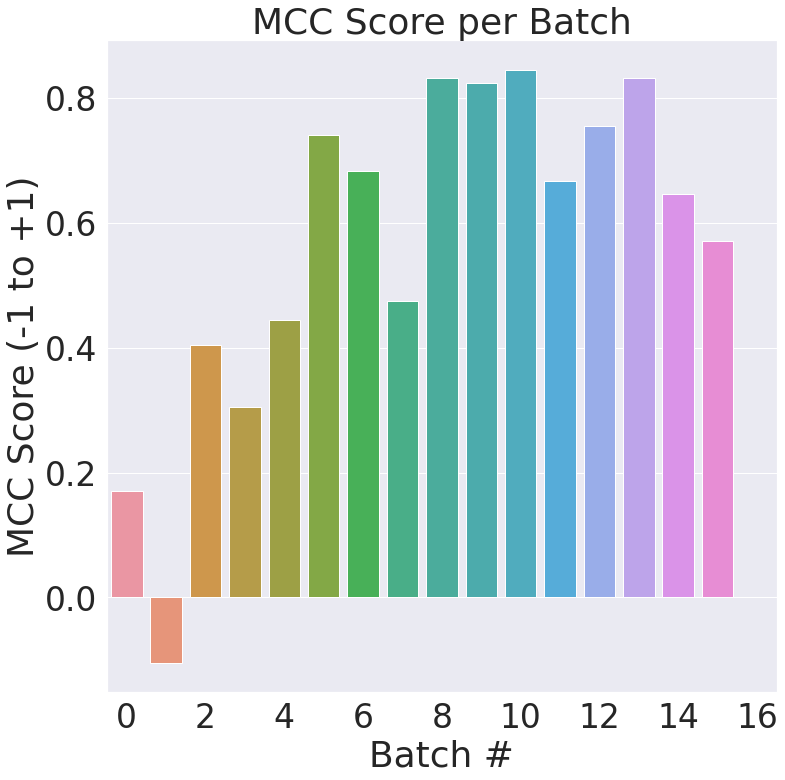

In [ ]:
result_mixed_normal = run_experiment(
    train_dataset + slang_train_dataset, val_dataset, prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.60
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.61
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.50
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.51
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
 

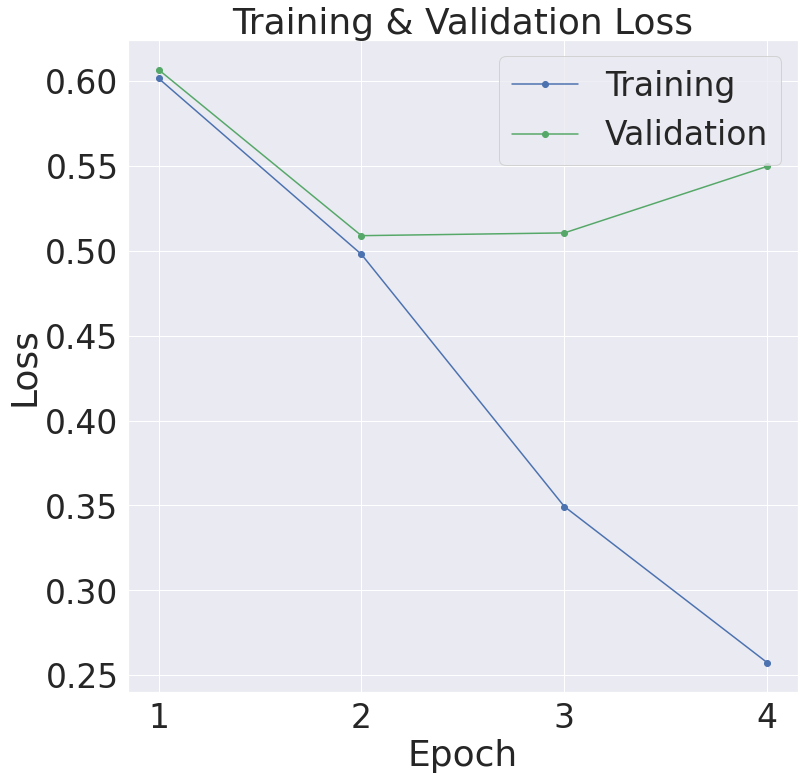

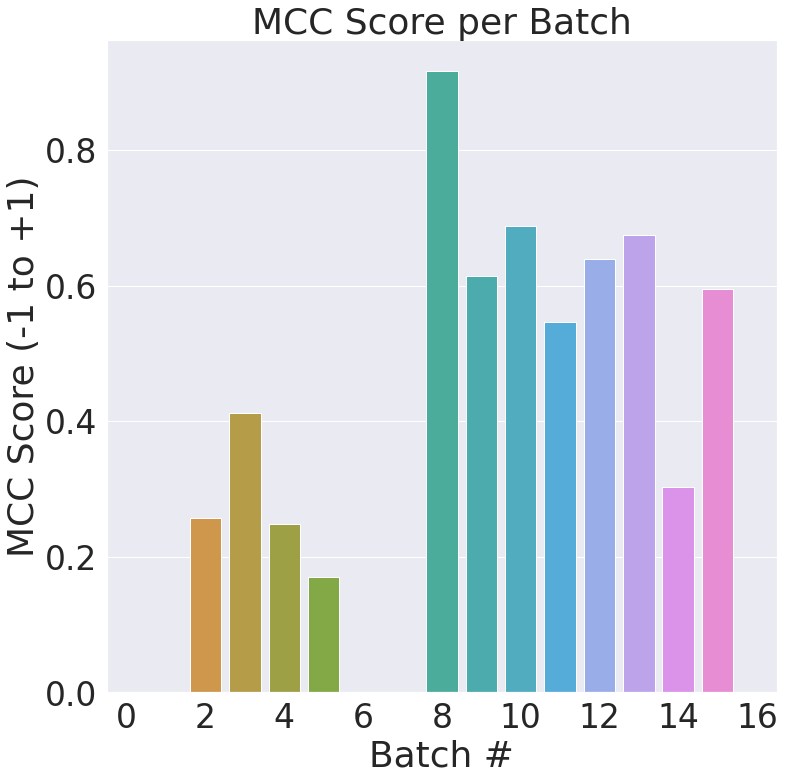

In [ ]:
result_slang_normal = run_experiment(
     slang_train_dataset, val_dataset, prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.50
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.60
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.31
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.60
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
 

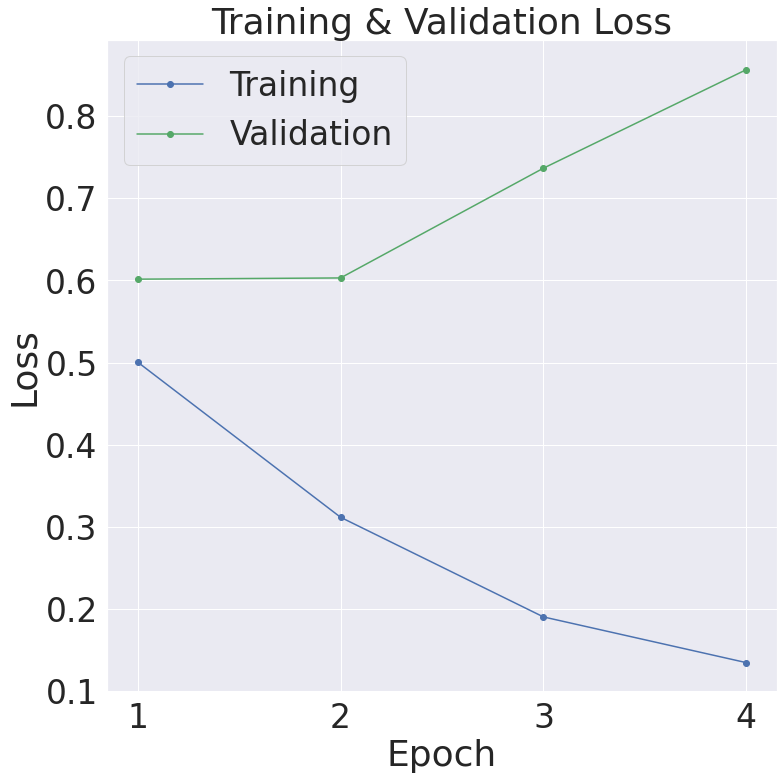

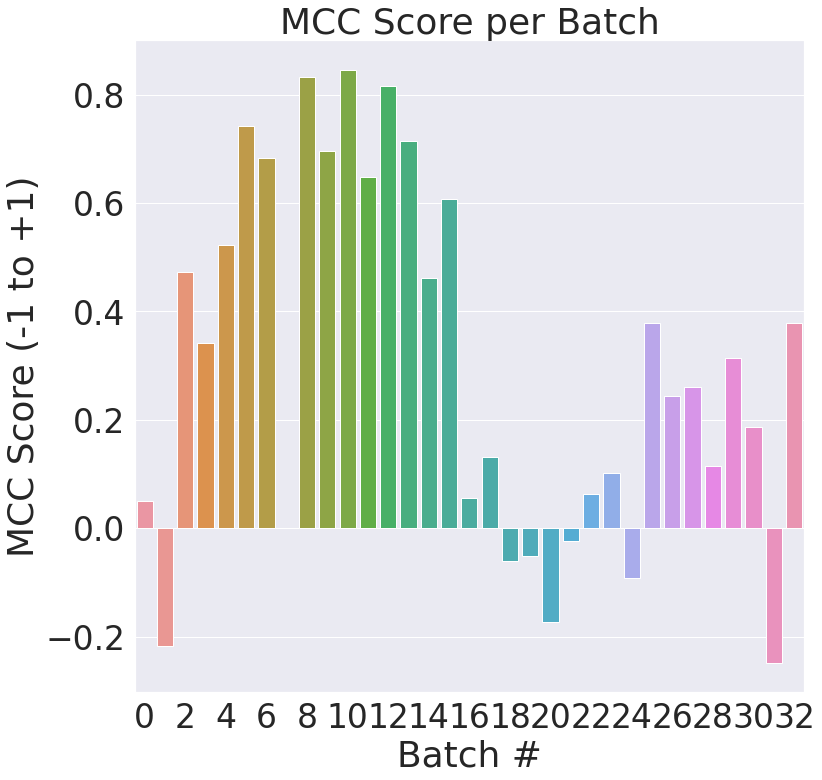

In [ ]:
result_normal_mixed = run_experiment(
    train_dataset, val_dataset + slang_val_dataset, prediction_dataset + slang_prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:16.
  Batch   120  of    481.    Elapsed: 0:00:24.
  Batch   160  of    481.    Elapsed: 0:00:32.
  Batch   200  of    481.    Elapsed: 0:00:40.
  Batch   240  of    481.    Elapsed: 0:00:48.
  Batch   280  of    481.    Elapsed: 0:00:56.
  Batch   320  of    481.    Elapsed: 0:01:04.
  Batch   360  of    481.    Elapsed: 0:01:12.
  Batch   400  of    481.    Elapsed: 0:01:19.
  Batch   440  of    481.    Elapsed: 0:01:27.
  Batch   480  of    481.    Elapsed: 0:01:35.

  Average training loss: 0.51
  Training epcoh took: 0:01:36

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.46
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:16.
  Batch   120  of    481.    Elapsed: 0:00:24.
  Batch   160  of    481.    Elapsed: 0:00:32.
  Batch  

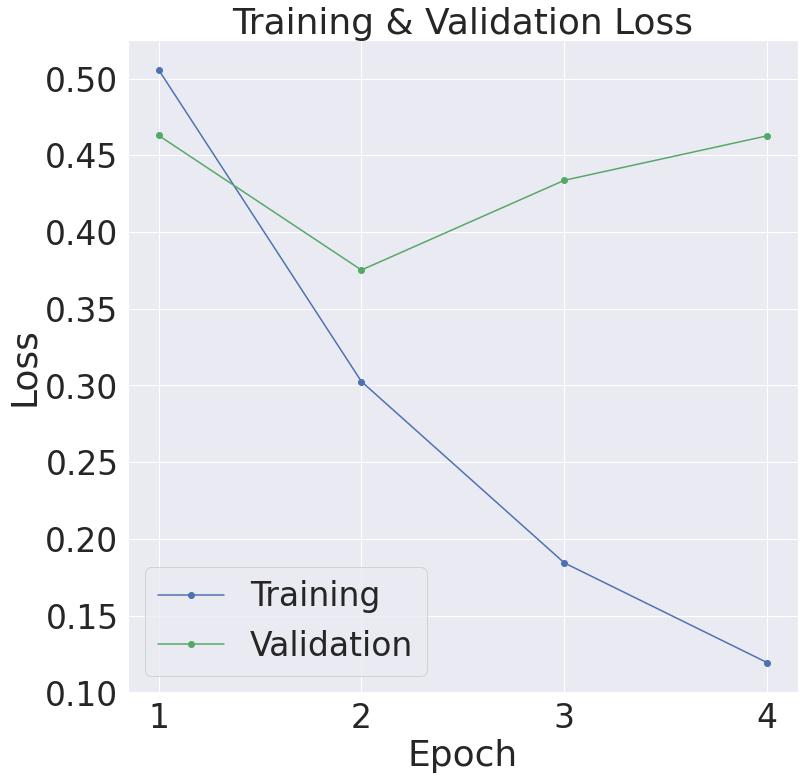

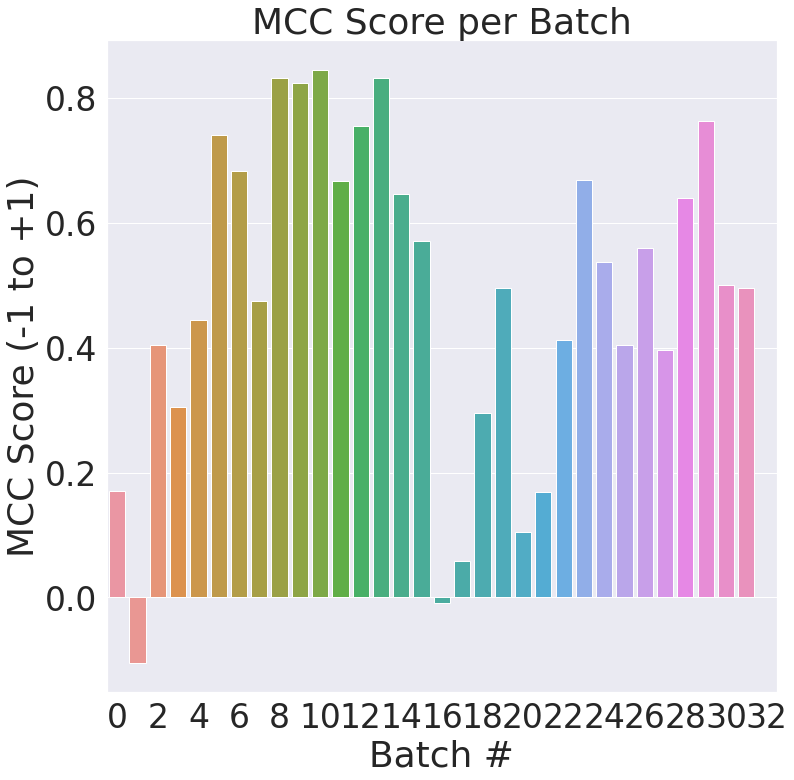

In [ ]:
result_mixed_mixed = run_experiment(
    train_dataset + slang_train_dataset, val_dataset + slang_val_dataset, prediction_dataset + slang_prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.60
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.59
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.50
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.52
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
 

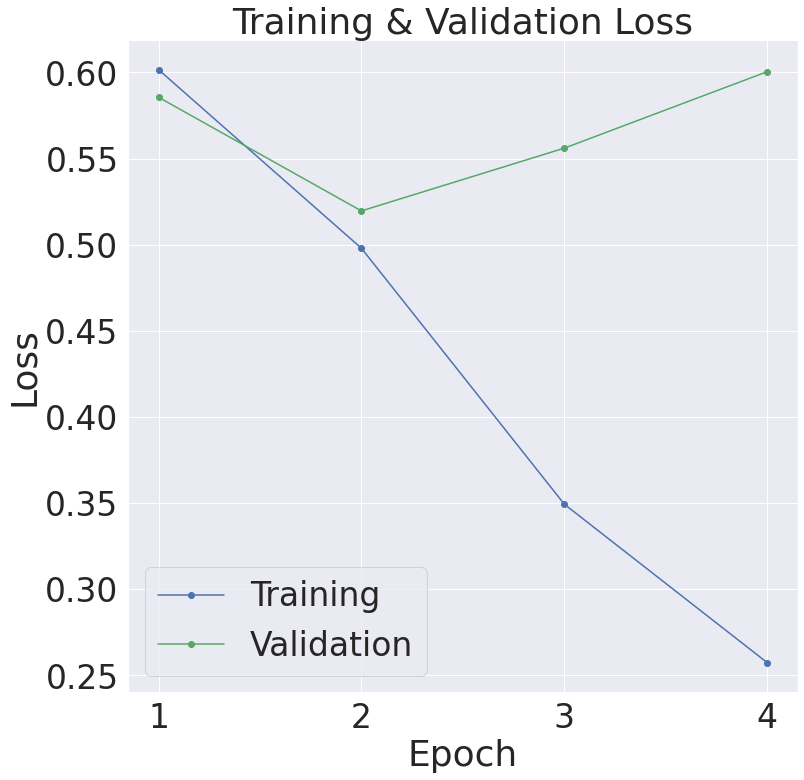

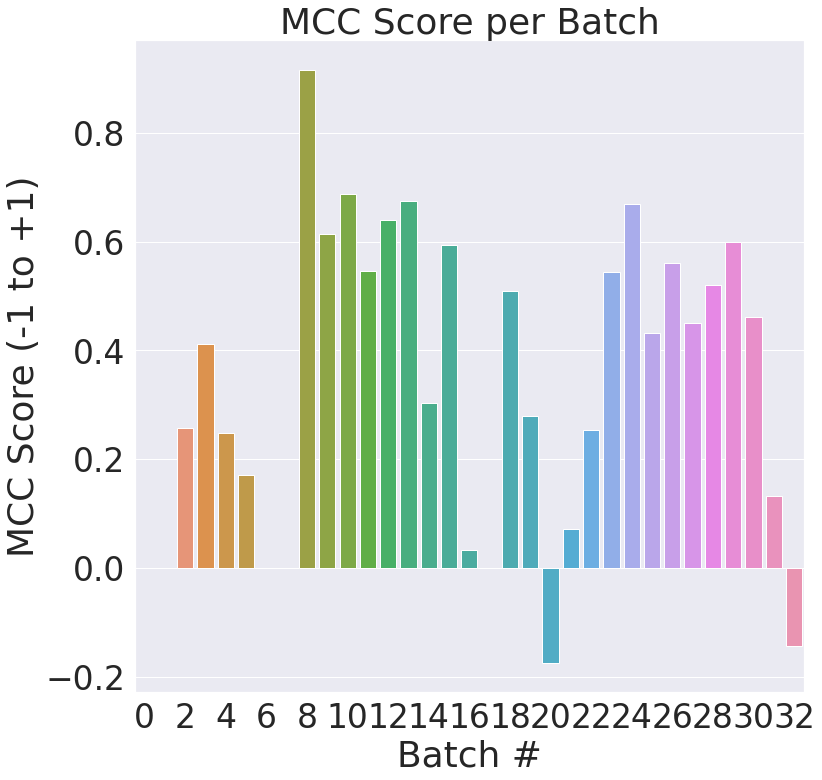

In [ ]:
result_slang_mixed = run_experiment(
     slang_train_dataset, val_dataset + slang_val_dataset, prediction_dataset + slang_prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.50
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.58
  Validation Loss: 0.74
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.31
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.63
  Validation Loss: 0.70
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
 

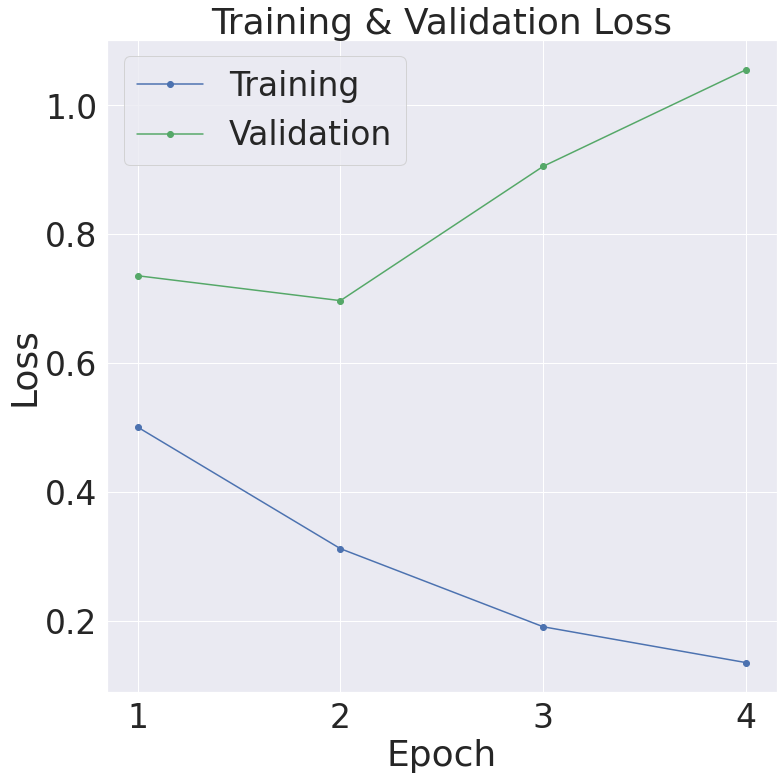

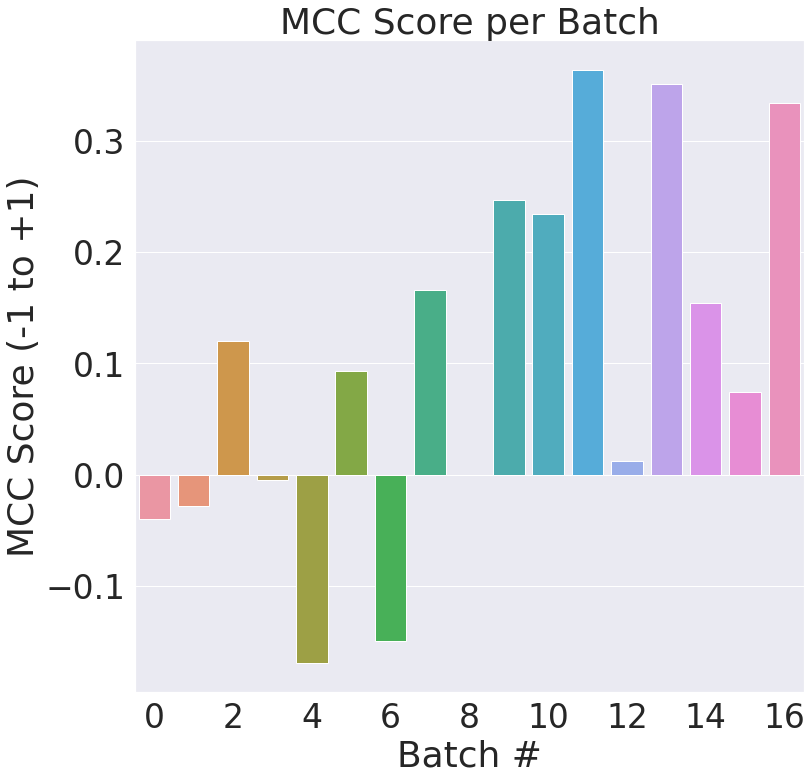

In [ ]:
result_normal_slang = run_experiment(
    train_dataset, slang_val_dataset, slang_prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:16.
  Batch   120  of    481.    Elapsed: 0:00:24.
  Batch   160  of    481.    Elapsed: 0:00:32.
  Batch   200  of    481.    Elapsed: 0:00:40.
  Batch   240  of    481.    Elapsed: 0:00:48.
  Batch   280  of    481.    Elapsed: 0:00:56.
  Batch   320  of    481.    Elapsed: 0:01:03.
  Batch   360  of    481.    Elapsed: 0:01:11.
  Batch   400  of    481.    Elapsed: 0:01:19.
  Batch   440  of    481.    Elapsed: 0:01:27.
  Batch   480  of    481.    Elapsed: 0:01:35.

  Average training loss: 0.51
  Training epcoh took: 0:01:35

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.47
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    481.    Elapsed: 0:00:08.
  Batch    80  of    481.    Elapsed: 0:00:16.
  Batch   120  of    481.    Elapsed: 0:00:24.
  Batch   160  of    481.    Elapsed: 0:00:32.
  Batch  

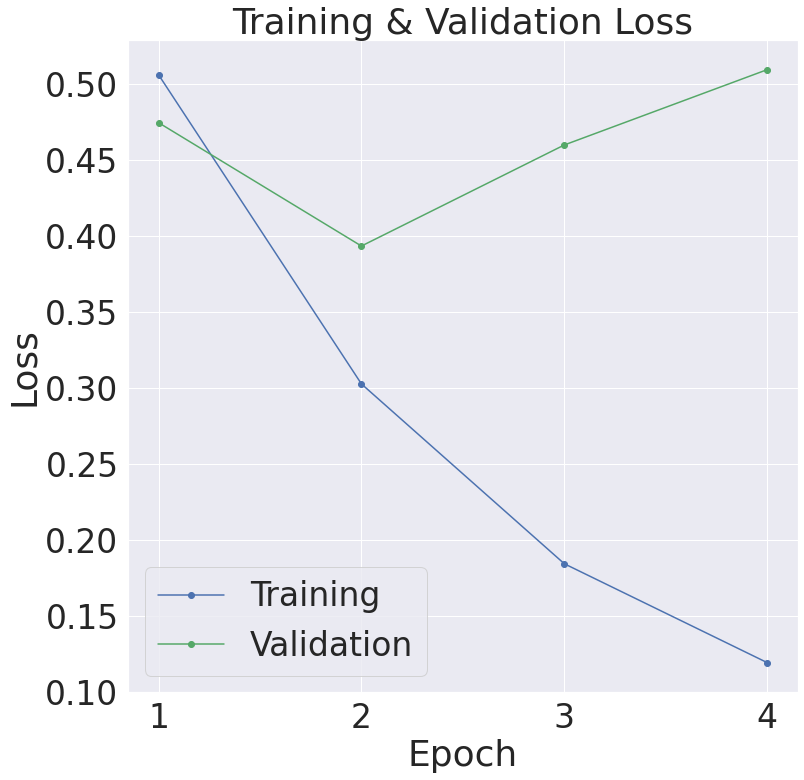

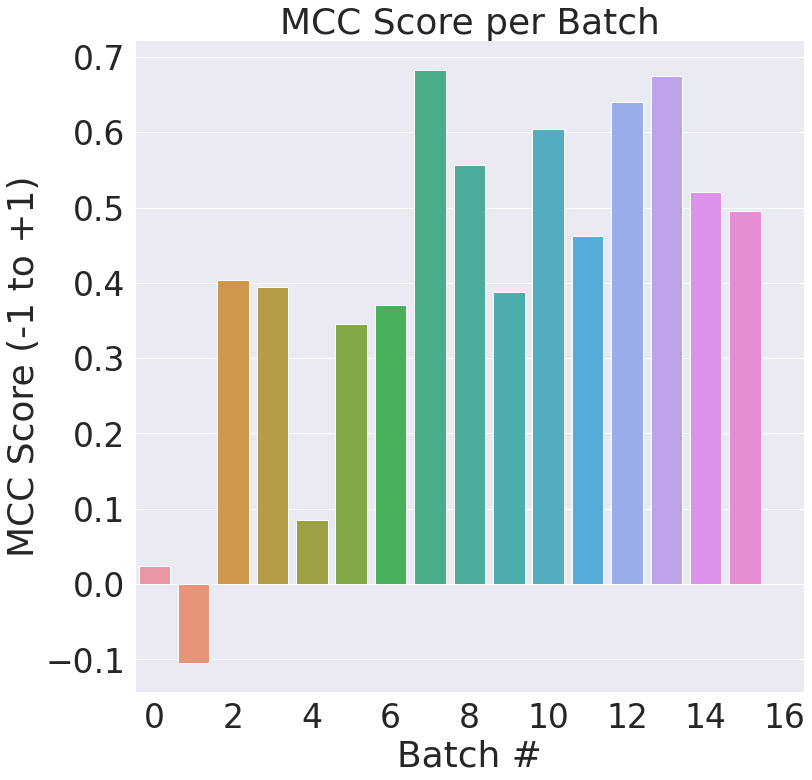

In [ ]:
result_mixed_slang = run_experiment(
    train_dataset + slang_train_dataset, slang_val_dataset, slang_prediction_dataset
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.60
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.57
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:08.
  Batch    80  of    241.    Elapsed: 0:00:16.
  Batch   120  of    241.    Elapsed: 0:00:24.
  Batch   160  of    241.    Elapsed: 0:00:32.
  Batch   200  of    241.    Elapsed: 0:00:40.
  Batch   240  of    241.    Elapsed: 0:00:48.

  Average training loss: 0.50
  Training epcoh took: 0:00:48

Running Validation...
  Accuracy: 0.76
  Validation Loss: 0.53
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
 

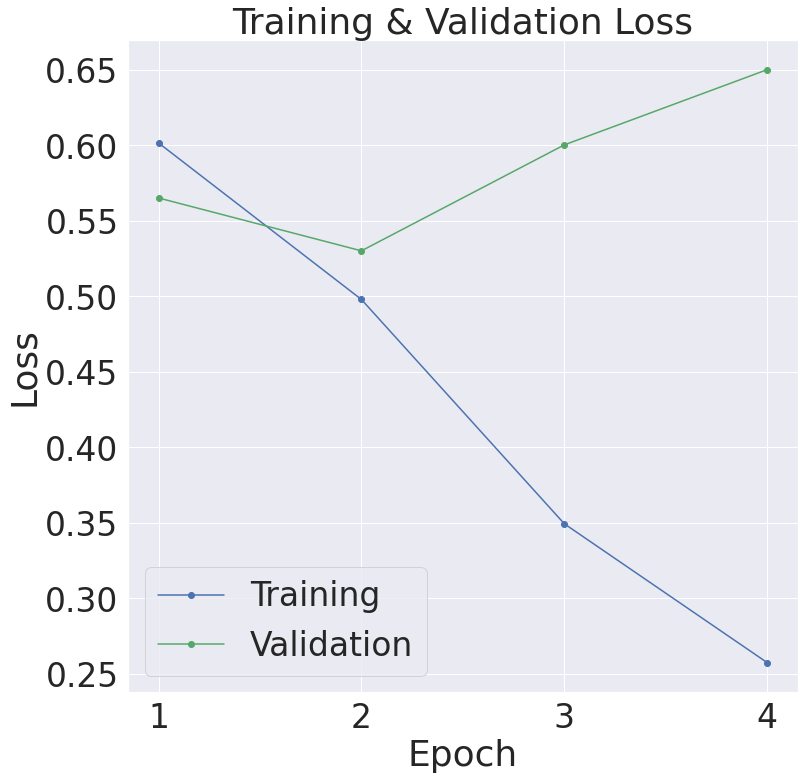

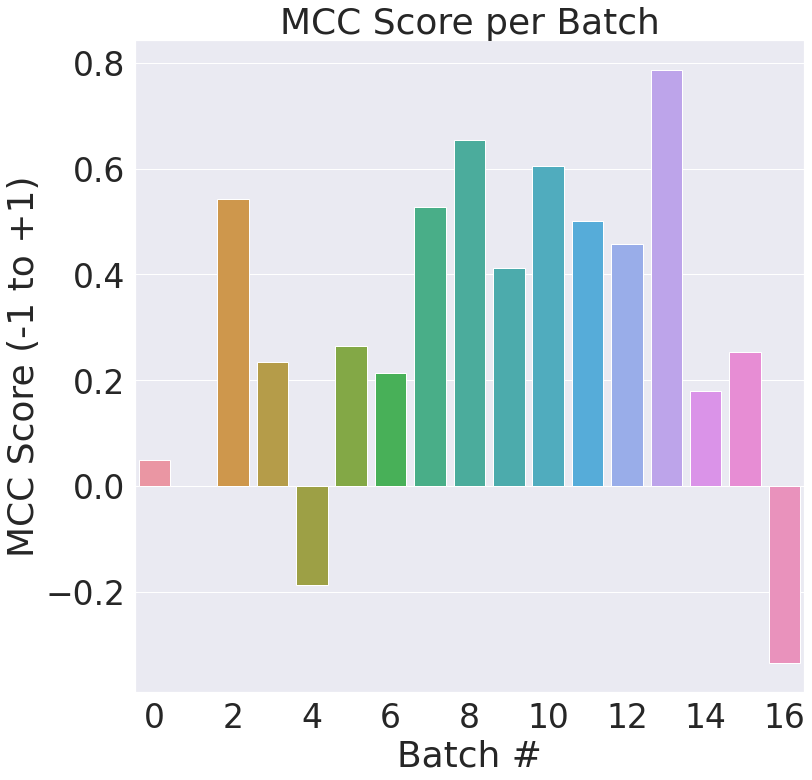

In [ ]:
result_slang_slang = run_experiment(
     slang_train_dataset, slang_val_dataset, slang_prediction_dataset
)

In [ ]:
results=pd.DataFrame({
"MCC":[result_normal_normal,result_slang_normal,result_mixed_normal,result_normal_mixed,result_slang_mixed,result_mixed_mixed,result_normal_slang,result_slang_slang,result_mixed_slang],
"Model":["Normal","Slang","Mixed","Normal","Slang","Mixed","Normal","Slang","Mixed"],
"Test":["Normal","Normal","Normal","Mixed","Mixed","Mixed","Slang","Slang","Slang"]
})

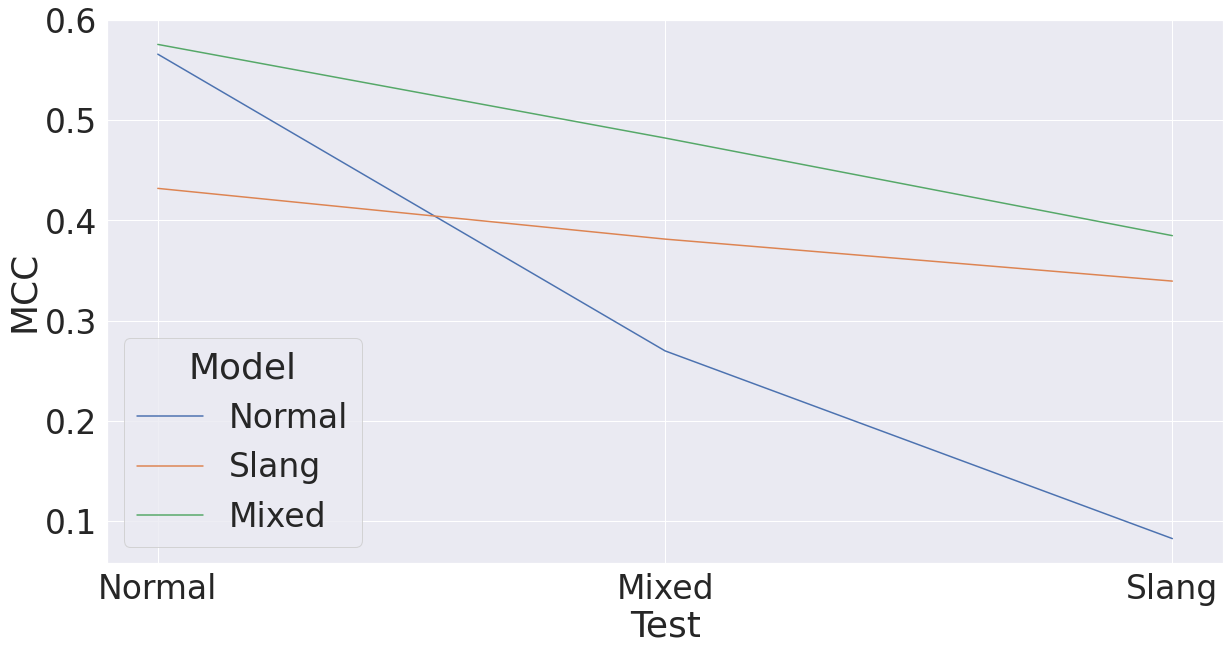

In [ ]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,10))
sns.lineplot(data=results,x="Test",y="MCC",hue="Model")
plt.show()